In [1]:
import warnings; 
warnings.simplefilter('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#import rpy2.robjects as robjects
import json
import pandas as pd
import numpy as np
import os

import datetime as dt
import seaborn as sb

import scipy as sp
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 10
from pandas.plotting import register_matplotlib_converters
import plotly.express as px
import plotly.graph_objects as go
import random


from pandas.plotting import scatter_matrix
register_matplotlib_converters()

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.stattools import durbin_watson
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [3]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

def forward_regression(X, y,
                       threshold_in,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

def backward_regression(X, y,
                           threshold_out,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

def forward_regression(X, y,
                       threshold_in,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

def backward_regression(X, y,
                           threshold_out,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [4]:
df = pd.read_excel('EXPERIMENTO.xlsx')
#df = pd.read_excel('DATASET_FINAL_2.xlsx')
#df2 = pd.read_excel('CALIFICAR_ABRIL_JULIO.xlsx')
df = pd.DataFrame(df)

KeyboardInterrupt: 

In [105]:
# Obtener los nombres de las columnas como una lista
nombres_columnas = list(df.columns)

In [106]:
nombres_columnas

['TIPO_VINCULACION_1',
 'NUMERO_HIJOS_1_TIPO_VINCULACION_1',
 'EDAD_3_TIPO_VINCULACION_1',
 'TIPO_VIVIENDA_1_TIPO_VINCULACION_1',
 'ANTIGUEDAD_NEGOCIO_1_TIPO_VINCULACION_1',
 'TIPO_VIVIENDA_1',
 'SCORE_3_TIPO_VINCULACION_1',
 'TIPO_VIVIENDA_1_EDAD_3',
 'SCORE_1_ACTIVOS_TOTAL_1',
 'SCORE_1',
 'VENTAS_2_TIPO_VINCULACION_1',
 'ACTIVOS_TOTAL_1',
 'RAZON_PASIVOS_ACTIVOS_2_TIPO_VINCULACION_1',
 'CIUDAD_1_ACTIVOS_TOTAL_1',
 'SCORE_1_TOTAL_PASIVOS_1',
 'ACTIVOS_TOTAL_2_TIPO_VINCULACION_1',
 'TOTAL_PASIVOS_1_ACTIVOS_TOTAL_1',
 'ESTADO_CIVIL_1_ACTIVOS_TOTAL_1',
 'SCORE_4',
 'VENTAS_2_ACTIVOS_TOTAL_1',
 'ANTIGUEDAD_NEGOCIO_1',
 'ACTIVOS_TOTAL_3',
 'ACTIVOS_TOTAL_1_TIPO_VIVIENDA_3',
 'ANTIGUEDAD_NEGOCIO_1_EDAD_3',
 'SCORE_4_EDAD_3',
 'TIPO_VIVIENDA_1_RAZON_PASIVOS_ACTIVOS_2',
 'NUMERO_HIJOS_1_EDAD_3',
 'SCORE_3',
 'SCORE_3_EDAD_3',
 'CIUDAD_1_TIPO_VINCULACION_1',
 'ESTADO_CIVIL_3_TIPO_VINCULACION_1',
 'SCORE_4_TIPO_VINCULACION_1',
 'TIPO_VIVIENDA_3',
 'EDAD_3',
 'SCORE_1_TIPO_VIVIENDA_3',
 'TOTAL_

In [107]:
variables=["EVENTO","CIUDAD_3_EDAD_3",
"SCORE_3",
"SCORE_4",
"EDAD_3_TIPO_VINCULACION_1",
"SCORE_1",
"TOTAL_PASIVOS_1_ACTIVOS_TOTAL_1",
"ANTIGUEDAD_NEGOCIO_1",
"ACTIVOS_TOTAL_3",
"NUMERO_HIJOS_1_EDAD_3",
"ESTADO_CIVIL_1_TIPO_VINCULACION_1",
"CIUDAD_1_TIPO_VIVIENDA_3",
"TOTAL_PASIVOS_2_RAZON_PASIVOS_ACTIVOS_2",
"EDAD_2_TIPO_VINCULACION_1",
"CIUDAD_1_ACTIVOS_TOTAL_1",
"TIPO_VIVIENDA_3",
"ACTIVOS_TOTAL_3_EDAD_3",
"CIUDAD_1_TOTAL_PASIVOS_1",
"CIIU_2_TOTAL_PASIVOS_1",
"ACTIVOS_TOTAL_3_GENERO_1",
"ESTADO_CIVIL_1",
"ANTIGUEDAD_NEGOCIO_1_TIPO_VINCULACION_1",
"TIPO_VIVIENDA_1",
"NUMERO_HIJOS_1",
"ACTIVOS_TOTAL_2_EDAD_3",
"TOTAL_PASIVOS_1",
"CIUDAD_3_TIPO_VINCULACION_1",
"NUMERO_HIJOS_1_RAZON_PASIVOS_ACTIVOS_2",
"CIIU_2_GENERO_1"]


In [102]:
continuas=['VENTAS','SCORE','RAZON_PASIVOS_ACTIVOS', 'EDAD', 'ANTIGUEDAD_NEGOCIO', 'TOTAL_PASIVOS', 'ACTIVOS_TOTAL']

categoricas=['EVENTO',"TIPO_VINCULACION_1",
"TIPO_VIVIENDA_1", "EDAD_2", "SCORE_2", "CIIU_2", "SCORE_3", "SCORE_4","ANTIGUEDAD_NEGOCIO_1","SCORE_1", 
"CIIU_6","ACTIVOS_TOTAL_1","GENERO_1",'ESTADO_CIVIL_3','EDAD_3','TOTAL_PASIVOS_3', 'RAZON_PASIVOS_ACTIVOS_2']

categoricas_2=["EVENTO", 
'TIPO_DE_VIVIENDA', 'TIPO_VINCULACION', 'CIUDAD',
'CIIU', 'GENERO', 'ESTADO_CIVIL','TIPO_VINCULACION_1',
 'TIPO_VIVIENDA_1',
 'SCORE_1',
 'ACTIVOS_TOTAL_1',
 'SCORE_4',
 'ANTIGUEDAD_NEGOCIO_1',
 'ACTIVOS_TOTAL_3',
 'SCORE_3',
 'EDAD_3',
 'TIPO_VIVIENDA_3',
 'ESTADO_CIVIL_3',
 'NUMERO_HIJOS_1',
 'EDAD_1',
 'TOTAL_PASIVOS_1',
 'ESTADO_CIVIL_1',
 'ACTIVOS_TOTAL_2',
 'CIIU_6',
 'TOTAL_PASIVOS_3',
 'SCORE_2',
 'EDAD_2',
 'CIIU_2',
 'CIUDAD_1',
 'CIUDAD_3',
 'GENERO_1',
 'VENTAS_2',
 'TOTAL_PASIVOS_2',
 'RAZON_PASIVOS_ACTIVOS_2',
"ANTIGUEDAD_NEGOCIO_1", 
"SCORE_1","CIIU_6", 
"EDAD_3:TOTAL_PASIVOS_1",
"TIPO_VINCULACION_1:CIUDAD_3", 
"ACTIVOS_TOTAL_1:CIUDAD_3",
"ACTIVOS_TOTAL_1:VENTAS_2", 
"TIPO_VINCULACION_1:TOTAL_PASIVOS_1",
"ACTIVOS_TOTAL_1:TIPO_VIVIENDA_3", 
"TIPO_VIVIENDA_1:SCORE_3",
"ESTADO_CIVIL_3:TOTAL_PASIVOS_1", 
"GENERO_1:EDAD_3",
"TIPO_VIVIENDA_1:CIUDAD_3", 
"RAZON_PASIVOS_ACTIVOS_1:EDAD_1", 
"ESTADO_CIVIL_3:TOTAL_PASIVOS_2"]


variables=categoricas
variables2=categoricas_2+continuas


In [108]:
variables

['EVENTO',
 'CIUDAD_3_EDAD_3',
 'SCORE_3',
 'SCORE_4',
 'EDAD_3_TIPO_VINCULACION_1',
 'SCORE_1',
 'TOTAL_PASIVOS_1_ACTIVOS_TOTAL_1',
 'ANTIGUEDAD_NEGOCIO_1',
 'ACTIVOS_TOTAL_3',
 'NUMERO_HIJOS_1_EDAD_3',
 'ESTADO_CIVIL_1_TIPO_VINCULACION_1',
 'CIUDAD_1_TIPO_VIVIENDA_3',
 'TOTAL_PASIVOS_2_RAZON_PASIVOS_ACTIVOS_2',
 'EDAD_2_TIPO_VINCULACION_1',
 'CIUDAD_1_ACTIVOS_TOTAL_1',
 'TIPO_VIVIENDA_3',
 'ACTIVOS_TOTAL_3_EDAD_3',
 'CIUDAD_1_TOTAL_PASIVOS_1',
 'CIIU_2_TOTAL_PASIVOS_1',
 'ACTIVOS_TOTAL_3_GENERO_1',
 'ESTADO_CIVIL_1',
 'ANTIGUEDAD_NEGOCIO_1_TIPO_VINCULACION_1',
 'TIPO_VIVIENDA_1',
 'NUMERO_HIJOS_1',
 'ACTIVOS_TOTAL_2_EDAD_3',
 'TOTAL_PASIVOS_1',
 'CIUDAD_3_TIPO_VINCULACION_1',
 'NUMERO_HIJOS_1_RAZON_PASIVOS_ACTIVOS_2',
 'CIIU_2_GENERO_1']

In [100]:
variables2

['EVENTO',
 'TIPO_DE_VIVIENDA',
 'TIPO_VINCULACION',
 'CIUDAD',
 'CIIU',
 'GENERO',
 'ESTADO_CIVIL',
 'TIPO_VINCULACION_1',
 'TIPO_VIVIENDA_1',
 'SCORE_1',
 'ACTIVOS_TOTAL_1',
 'SCORE_4',
 'ANTIGUEDAD_NEGOCIO_1',
 'ACTIVOS_TOTAL_3',
 'SCORE_3',
 'EDAD_3',
 'TIPO_VIVIENDA_3',
 'ESTADO_CIVIL_3',
 'NUMERO_HIJOS_1',
 'EDAD_1',
 'TOTAL_PASIVOS_1',
 'ESTADO_CIVIL_1',
 'ACTIVOS_TOTAL_2',
 'CIIU_6',
 'TOTAL_PASIVOS_3',
 'SCORE_2',
 'EDAD_2',
 'CIIU_2',
 'CIUDAD_1',
 'CIUDAD_3',
 'GENERO_1',
 'VENTAS_2',
 'TOTAL_PASIVOS_2',
 'RAZON_PASIVOS_ACTIVOS_2',
 'ANTIGUEDAD_NEGOCIO_1',
 'SCORE_1',
 'CIIU_6',
 'EDAD_3:TOTAL_PASIVOS_1',
 'TIPO_VINCULACION_1:CIUDAD_3',
 'ACTIVOS_TOTAL_1:CIUDAD_3',
 'ACTIVOS_TOTAL_1:VENTAS_2',
 'TIPO_VINCULACION_1:TOTAL_PASIVOS_1',
 'ACTIVOS_TOTAL_1:TIPO_VIVIENDA_3',
 'TIPO_VIVIENDA_1:SCORE_3',
 'ESTADO_CIVIL_3:TOTAL_PASIVOS_1',
 'GENERO_1:EDAD_3',
 'TIPO_VIVIENDA_1:CIUDAD_3',
 'RAZON_PASIVOS_ACTIVOS_1:EDAD_1',
 'ESTADO_CIVIL_3:TOTAL_PASIVOS_2',
 'VENTAS',
 'SCORE',
 'RAZON_

In [51]:
df1 = df[variables]

# Crear interacciones de GENERO_1 con las demás variables y ESTADO_CIVIL_2 con las demás variables
interactions = df1.copy()

for var in variables:
    if var != 'EVENTO' and var != 'TIPO_VINCULACION_1':
        interactions[f'TIPO_VINCULACION_1:{var}'] = df1['TIPO_VINCULACION_1'] * df1[var]
    
    if var != 'EVENTO' and var != 'ACTIVOS_TOTAL_1':
        interactions[f'ACTIVOS_TOTAL_1:{var}'] = df1['ACTIVOS_TOTAL_1'] * df1[var]
        
    if var != 'EVENTO' and var != 'TIPO_VIVIENDA_1':
        interactions[f'TIPO_VIVIENDA_1:{var}'] = df1['TIPO_VIVIENDA_1'] * df1[var]
    
    if var != 'EVENTO' and var != 'GENERO_1':
        interactions[f'GENERO_1:{var}'] = df1['GENERO_1'] * df1[var]
    
    if var != 'EVENTO' and var != 'ESTADO_CIVIL_3':
        interactions[f'ESTADO_CIVIL_3:{var}'] = df1['ESTADO_CIVIL_3'] * df1[var]
    
    if var != 'EVENTO' and var != 'EDAD_3':
        interactions[f'EDAD_3:{var}'] = df1['EDAD_3'] * df1[var]
        
    if var != 'EVENTO' and var != 'TOTAL_PASIVOS_3':
        interactions[f'TOTAL_PASIVOS_3:{var}'] = df1['TOTAL_PASIVOS_3'] * df1[var]
        
    if var != 'EVENTO' and var != 'RAZON_PASIVOS_ACTIVOS_2':
        interactions[f'RAZON_PASIVOS_ACTIVOS_2:{var}'] = df1['RAZON_PASIVOS_ACTIVOS_2'] * df1[var]

In [52]:
variables=list(interactions.columns)

In [123]:
variables

['EVENTO',
 'CIUDAD_3_EDAD_3',
 'SCORE_3',
 'SCORE_4',
 'EDAD_3_TIPO_VINCULACION_1',
 'SCORE_1',
 'TOTAL_PASIVOS_1_ACTIVOS_TOTAL_1',
 'ANTIGUEDAD_NEGOCIO_1',
 'ACTIVOS_TOTAL_3',
 'NUMERO_HIJOS_1_EDAD_3',
 'ESTADO_CIVIL_1_TIPO_VINCULACION_1',
 'CIUDAD_1_TIPO_VIVIENDA_3',
 'TOTAL_PASIVOS_2_RAZON_PASIVOS_ACTIVOS_2',
 'EDAD_2_TIPO_VINCULACION_1',
 'CIUDAD_1_ACTIVOS_TOTAL_1',
 'TIPO_VIVIENDA_3',
 'ACTIVOS_TOTAL_3_EDAD_3',
 'CIUDAD_1_TOTAL_PASIVOS_1',
 'CIIU_2_TOTAL_PASIVOS_1',
 'ACTIVOS_TOTAL_3_GENERO_1',
 'ESTADO_CIVIL_1',
 'ANTIGUEDAD_NEGOCIO_1_TIPO_VINCULACION_1',
 'TIPO_VIVIENDA_1',
 'NUMERO_HIJOS_1',
 'ACTIVOS_TOTAL_2_EDAD_3',
 'TOTAL_PASIVOS_1',
 'CIUDAD_3_TIPO_VINCULACION_1',
 'NUMERO_HIJOS_1_RAZON_PASIVOS_ACTIVOS_2',
 'CIIU_2_GENERO_1']

In [126]:
df1 = df[variables]

In [135]:
X=pd.DataFrame(df1,columns= variables)
# Suponiendo que 'df' es tu dataframe y 'variables' es una lista con los nombres de las variables
X = df1.drop(columns=['EVENTO'])

In [136]:
y1=df['EVENTO']

In [139]:
L1=backward_regression(X, y1, 0.05, verbose=False)

In [140]:
L1

['CIUDAD_3_EDAD_3',
 'SCORE_3',
 'SCORE_4',
 'EDAD_3_TIPO_VINCULACION_1',
 'SCORE_1',
 'TOTAL_PASIVOS_1_ACTIVOS_TOTAL_1',
 'ANTIGUEDAD_NEGOCIO_1',
 'ACTIVOS_TOTAL_3',
 'ESTADO_CIVIL_1_TIPO_VINCULACION_1',
 'CIUDAD_1_TIPO_VIVIENDA_3',
 'TOTAL_PASIVOS_2_RAZON_PASIVOS_ACTIVOS_2',
 'EDAD_2_TIPO_VINCULACION_1',
 'CIUDAD_1_ACTIVOS_TOTAL_1',
 'TIPO_VIVIENDA_3',
 'CIUDAD_1_TOTAL_PASIVOS_1',
 'ESTADO_CIVIL_1',
 'ANTIGUEDAD_NEGOCIO_1_TIPO_VINCULACION_1',
 'TIPO_VIVIENDA_1',
 'TOTAL_PASIVOS_1',
 'CIUDAD_3_TIPO_VINCULACION_1',
 'CIIU_2_GENERO_1']

In [141]:
L2=forward_regression(X, y1, 0.05, verbose=False)

In [142]:
L2

['EDAD_3_TIPO_VINCULACION_1',
 'SCORE_1',
 'TIPO_VIVIENDA_1',
 'EDAD_2_TIPO_VINCULACION_1',
 'CIUDAD_1_ACTIVOS_TOTAL_1',
 'SCORE_4',
 'SCORE_3',
 'ACTIVOS_TOTAL_3',
 'CIIU_2_GENERO_1',
 'TIPO_VIVIENDA_3',
 'ANTIGUEDAD_NEGOCIO_1',
 'ESTADO_CIVIL_1',
 'ESTADO_CIVIL_1_TIPO_VINCULACION_1',
 'CIUDAD_3_EDAD_3',
 'ANTIGUEDAD_NEGOCIO_1_TIPO_VINCULACION_1',
 'CIUDAD_1_TIPO_VIVIENDA_3',
 'CIUDAD_3_TIPO_VINCULACION_1']

In [94]:
X['EVENTO']=df['EVENTO']
X['CREDITO']=df['CREDITO']
X['IDENTIFICACION']=df['IDENTIFICACION']
X['SCORE']=df['SCORE']
#X['MES_PERFILAMIENTO']=df['MES_PERFILAMIENTO']

In [95]:
X

,EVENTO,TIPO_VINCULACION_1,TIPO_VIVIENDA_1,EDAD_2,SCORE_2,CIIU_2,SCORE_3,ANTIGUEDAD_NEGOCIO_1,SCORE_1,CIIU_6,ACTIVOS_TOTAL_1,GENERO_1,ESTADO_CIVIL_3,EDAD_3,TOTAL_PASIVOS_3,RAZON_PASIVOS_ACTIVOS_2,CREDITO,IDENTIFICACION,SCORE
0,0,1,0,0,1,1,0,1,0,0,0,1,1,1,0,1,80000068188,93366264,656
1,0,1,1,0,0,0,1,1,0,0,0,1,0,1,0,0,80000068192,13537087,712
2,0,1,1,0,1,0,0,1,0,1,0,0,0,1,0,1,80000068193,35510406,620
3,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,80000068195,40079073,776
4,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,80000068196,40784068,607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19000,0,1,1,0,0,1,1,1,0,0,0,1,0,1,1,0,80000098292,78026774,785
19001,0,0,0,0,0,0,1,1,0,0,1,1,1,1,0,0,80000098293,6884451,764
19002,1,0,0,0,1,0,0,1,0,0,0,1,1,1,1,0,80000098294,6301768,634
19003,0,1,1,0,0,0,1,1,0,1,0,0,0,1,0,1,80000098295,36999459,803


In [ ]:
#X.to_excel('BASE_INTERACCIONES.xlsx', index=False)
#X.to_excel('BASE_INTERACCIONES_CALIF2.xlsx', index=False)

##### Se toman las variables que de acuerdo al IV tienen una potencia de predictividad alta y media

###### Metodología)
###### 1) Aplicar un Backward con la función 2) por la cantidad de variables, tomando en principio las variables originales sin lags junto con sus variabilidades.

In [78]:
df1=pd.DataFrame(df,columns= variables2)
#df1.describe()

In [75]:
df1.list(df1.columns)

['EVENTO',
 'TIPO_DE_VIVIENDA',
 'TIPO_VINCULACION',
 'CIUDAD',
 'CIIU',
 'GENERO',
 'ESTADO_CIVIL',
 'TIPO_VINCULACION_1',
 'TIPO_VIVIENDA_1',
 'SCORE_1',
 'ACTIVOS_TOTAL_1',
 'SCORE_4',
 'ANTIGUEDAD_NEGOCIO_1',
 'ACTIVOS_TOTAL_3',
 'SCORE_3',
 'EDAD_3',
 'TIPO_VIVIENDA_3',
 'ESTADO_CIVIL_3',
 'NUMERO_HIJOS_1',
 'EDAD_1',
 'TOTAL_PASIVOS_1',
 'ESTADO_CIVIL_1',
 'ACTIVOS_TOTAL_2',
 'CIIU_6',
 'TOTAL_PASIVOS_3',
 'SCORE_2',
 'EDAD_2',
 'CIIU_2',
 'CIUDAD_1',
 'CIUDAD_3',
 'GENERO_1',
 'VENTAS_2',
 'TOTAL_PASIVOS_2',
 'RAZON_PASIVOS_ACTIVOS_2',
 'ANTIGUEDAD_NEGOCIO_1',
 'SCORE_1',
 'CIIU_6',
 'EDAD_3:TOTAL_PASIVOS_1',
 'TIPO_VINCULACION_1:CIUDAD_3',
 'ACTIVOS_TOTAL_1:CIUDAD_3',
 'ACTIVOS_TOTAL_1:VENTAS_2',
 'TIPO_VINCULACION_1:TOTAL_PASIVOS_1',
 'ACTIVOS_TOTAL_1:TIPO_VIVIENDA_3',
 'TIPO_VIVIENDA_1:SCORE_3',
 'ESTADO_CIVIL_3:TOTAL_PASIVOS_1',
 'GENERO_1:EDAD_3',
 'TIPO_VIVIENDA_1:CIUDAD_3',
 'RAZON_PASIVOS_ACTIVOS_1:EDAD_1',
 'ESTADO_CIVIL_3:TOTAL_PASIVOS_2',
 'VENTAS',
 'SCORE',
 'RAZON_

### Análisis de correlación 

In [71]:
X=pd.DataFrame(df,columns= continuas)

,VENTAS,SCORE,RAZON_PASIVOS_ACTIVOS,EDAD,ANTIGUEDAD_NEGOCIO,TOTAL_PASIVOS,ACTIVOS_TOTAL
VENTAS,100.0,10.0,-0.0,1.0,8.0,40.0,39.0
SCORE,10.0,100.0,-0.0,33.0,21.0,14.0,19.0
RAZON_PASIVOS_ACTIVOS,-0.0,-0.0,100.0,1.0,-0.0,-0.0,-1.0
EDAD,1.0,33.0,1.0,100.0,53.0,16.0,23.0
ANTIGUEDAD_NEGOCIO,8.0,21.0,-0.0,53.0,100.0,17.0,23.0
TOTAL_PASIVOS,40.0,14.0,-0.0,16.0,17.0,100.0,54.0
ACTIVOS_TOTAL,39.0,19.0,-1.0,23.0,23.0,54.0,100.0


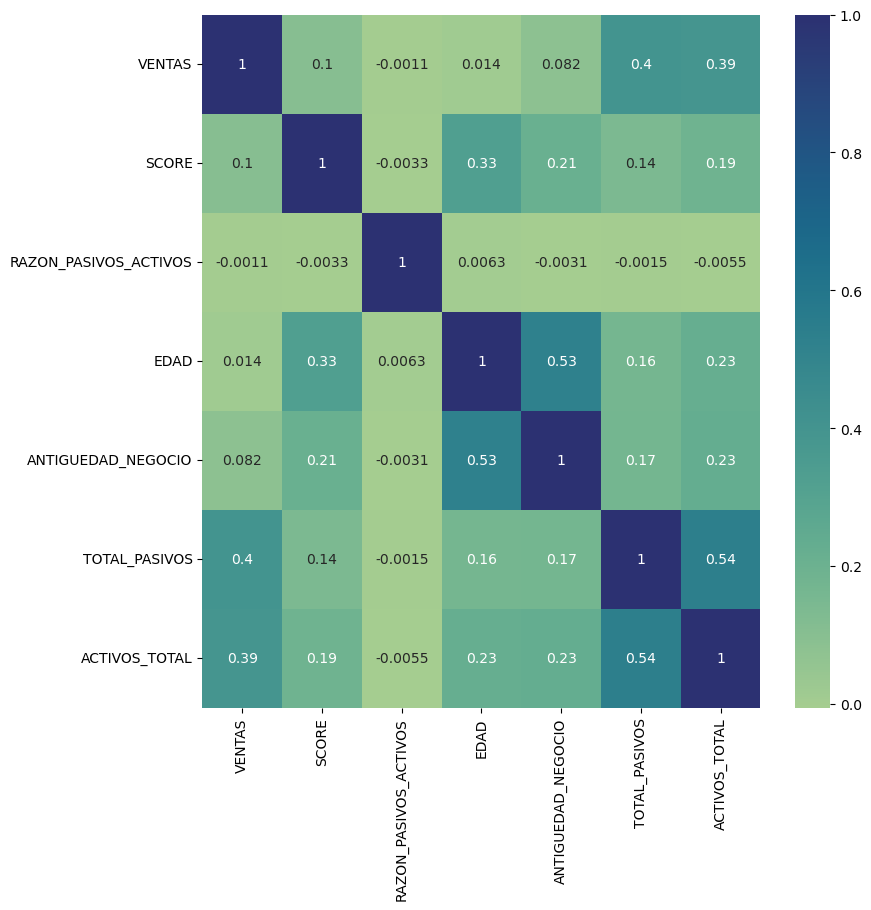

In [72]:
cmap = sb.color_palette("crest", as_cmap=True)
round(X.corr(),2)*100
fig, ax = plt.subplots(figsize=(9, 9))
heatmap=sb.heatmap(X.corr(), annot=True, cmap=cmap)
#heatmap.get_figure().savefig("C:/Users/damartinezp/Documents/Proyectos Borrador/PD_C1/Descriptivas/heatmap.png")

### Descriptiva dataset

In [6]:
df = pd.read_excel('EXPERIMENTO.xlsx')
#df = pd.read_excel('DATASET_FINAL_2.xlsx')
df2 = pd.read_excel('CALIFICAR_ABRIL_JULIO.xlsx')
df = pd.DataFrame(df)
df2 = pd.DataFrame(df2)

In [122]:
list(df2.columns)

['CREDITO',
 'TIPO_IDENTIFICACION',
 'IDENTIFICACION',
 'EVENTO',
 'SCORE',
 'EDAD',
 'NUMERO_HIJOS',
 'PERSONAS_A_CARGO',
 'EXPERIENCIA_ACTIVIDAD',
 'ANTIGUEDAD_NEGOCIO',
 'TIEMPO_LOCAL',
 'TIEMPO_VIVIR_VIVIENDA',
 'VENTAS',
 'COSTO_DE_VENTAS',
 'UTILIDAD_BRUTA',
 'REMUNERACION_PERSONAL',
 'CUOTAS_FINANCIERAS',
 'TOTAL_GASTOS',
 'UTILIDAD_MICROEMPRESA',
 'INGRESOS_FAMILIARES',
 'EGRESOS_FAMILIARES',
 'BANCOS',
 'ACTIVOS_TOTAL',
 'OBLIGACIONES_FINANCIERAS',
 'TOTAL_PASIVOS',
 'TOTAL_PATRIMONIO',
 'TIPO_VINCULACION',
 'ESTRATO',
 'GENERO',
 'ESTADO_CIVIL',
 'TIPO_DE_VIVIENDA',
 'CIUDAD',
 'CIIU',
 'DESTINO_CREDITO',
 'FECHA_PERFILAMIENTO',
 'RAZON_PASIVOS_ACTIVOS',
 'MES_PERFILAMIENTO',
 'SCORE_1',
 'SCORE_2',
 'SCORE_3',
 'SCORE_4',
 'TIPO_VINCULACION_1',
 'TIPO_VIVIENDA_1',
 'TIPO_VIVIENDA_2',
 'TIPO_VIVIENDA_3',
 'ACTIVOS_TOTAL_1',
 'ACTIVOS_TOTAL_2',
 'ACTIVOS_TOTAL_3',
 'EDAD_1',
 'EDAD_2',
 'EDAD_3',
 'ANTIGUEDAD_NEGOCIO_1',
 'CIIU_1',
 'CIIU_2',
 'CIIU_3',
 'CIIU_4',
 'CIIU_5',
 

In [7]:
variables=['EVENTO', 'ACTIVOS_TOTAL_3',
 'ANTIGUEDAD_NEGOCIO_1',
 'ANTIGUEDAD_NEGOCIO_1_TIPO_VINCULACION_1',
 'CIIU_2_GENERO_1',
 'CIUDAD_1_ACTIVOS_TOTAL_1',
 'CIUDAD_1_TIPO_VIVIENDA_3',
 'CIUDAD_1_TOTAL_PASIVOS_1',
 'CIUDAD_3_EDAD_3',
 'CIUDAD_3_TIPO_VINCULACION_1',
 'EDAD_2_TIPO_VINCULACION_1',
 'EDAD_3_TIPO_VINCULACION_1',
 'ESTADO_CIVIL_1',
 'ESTADO_CIVIL_1_TIPO_VINCULACION_1',
 'SCORE_1',
 'SCORE_3',
 'SCORE_4',
 'TIPO_VIVIENDA_1',
 'TIPO_VIVIENDA_3',
 'TOTAL_PASIVOS_1',
 #'TOTAL_PASIVOS_1_ACTIVOS_TOTAL_1',
 'TOTAL_PASIVOS_2_RAZON_PASIVOS_ACTIVOS_2']

lista=['EVENTO', 'ACTIVOS_TOTAL_3',
 'ANTIGUEDAD_NEGOCIO_1',
 'ANTIGUEDAD_NEGOCIO_1_TIPO_VINCULACION_1',
 'CIIU_2_GENERO_1',
 'CIUDAD_1_ACTIVOS_TOTAL_1',
 'CIUDAD_1_TIPO_VIVIENDA_3',
 'CIUDAD_1_TOTAL_PASIVOS_1',
 'CIUDAD_3_EDAD_3',
 'CIUDAD_3_TIPO_VINCULACION_1',
 'EDAD_2_TIPO_VINCULACION_1',
 'EDAD_3_TIPO_VINCULACION_1',
 'ESTADO_CIVIL_1',
 'ESTADO_CIVIL_1_TIPO_VINCULACION_1',
 'SCORE_1',
 'SCORE_3',
 'SCORE_4',
 'TIPO_VIVIENDA_1',
 'TIPO_VIVIENDA_3',
 'TOTAL_PASIVOS_1',
 #'TOTAL_PASIVOS_1_ACTIVOS_TOTAL_1',
 'TOTAL_PASIVOS_2_RAZON_PASIVOS_ACTIVOS_2']

In [9]:
#Solo cuando vaya a concatenar correr este código
df1=df[variables]
df3=df2[variables]

df_concatenado = pd.concat([df1, df3], axis=0)
df1=df_concatenado

In [13]:
df1

,EVENTO,ACTIVOS_TOTAL_3,ANTIGUEDAD_NEGOCIO_1,ANTIGUEDAD_NEGOCIO_1_TIPO_VINCULACION_1,CIIU_2_GENERO_1,CIUDAD_1_ACTIVOS_TOTAL_1,CIUDAD_1_TIPO_VIVIENDA_3,CIUDAD_1_TOTAL_PASIVOS_1,CIUDAD_3_EDAD_3,CIUDAD_3_TIPO_VINCULACION_1,...,EDAD_3_TIPO_VINCULACION_1,ESTADO_CIVIL_1,ESTADO_CIVIL_1_TIPO_VINCULACION_1,SCORE_1,SCORE_3,SCORE_4,TIPO_VIVIENDA_1,TIPO_VIVIENDA_3,TOTAL_PASIVOS_1,TOTAL_PASIVOS_2_RAZON_PASIVOS_ACTIVOS_2
0,0,1,1,1,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0,0,1,1,0,0,0,0,1,1,...,1,1,1,0,1,0,1,0,1,0
2,0,1,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
4,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,0,0,1,1,0,0,0,0,1,1,...,1,0,0,0,0,0,0,1,0,0
1306,0,0,1,1,0,1,0,0,0,0,...,0,1,1,0,1,0,1,0,0,0
1307,0,0,1,1,1,0,0,0,1,1,...,1,1,1,0,1,0,1,0,1,0
1308,0,0,0,0,1,0,0,0,0,1,...,0,1,1,0,1,0,0,1,1,0


<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='ACTIVOS_TOTAL_3', ylabel='proportion'>

Text(0.5, 0, 'ACTIVOS TOTALES MAYORES A 112.6 SMLV')

Text(0, 0.5, 'Proporción')

Text(0.5, 1.0, 'Gráfico de barras proporcionales')

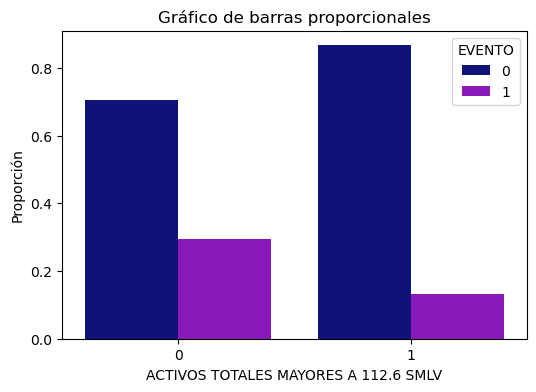

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['ACTIVOS_TOTAL_3', 'EVENTO']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('ACTIVOS_TOTAL_3')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(data=counts, x="ACTIVOS_TOTAL_3", y='proportion', palette=['darkblue', 'darkviolet'], hue='EVENTO')

# Personalizar el gráfico
plt.xlabel('ACTIVOS TOTALES MAYORES A 112.6 SMLV')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [78]:
counts

,ACTIVOS_TOTAL_3,EVENTO,count,proportion
0,0,0,12854,0.705992
1,0,1,5353,0.294008
2,1,0,1827,0.866698
3,1,1,281,0.133302


<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='ANTIGUEDAD_NEGOCIO_1', ylabel='proportion'>

Text(0.5, 0, 'ANTIGUEDAD NEGOCIO MAYOR A 60 MESES')

Text(0, 0.5, 'Proporción')

Text(0.5, 1.0, 'Gráfico de barras proporcionales')

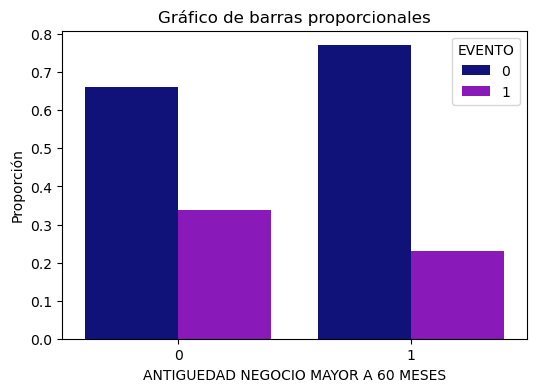

In [79]:
counts = df1.groupby(['ANTIGUEDAD_NEGOCIO_1', 'EVENTO']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('ANTIGUEDAD_NEGOCIO_1')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(data=counts, x="ANTIGUEDAD_NEGOCIO_1", y='proportion', palette=['darkblue', 'darkviolet'], hue='EVENTO')

# Personalizar el gráfico
plt.xlabel('ANTIGUEDAD NEGOCIO MAYOR A 60 MESES')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [80]:
counts

,ANTIGUEDAD_NEGOCIO_1,EVENTO,count,proportion
0,0,0,5849,0.660755
1,0,1,3003,0.339245
2,1,0,8832,0.770479
3,1,1,2631,0.229521


<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='ANTIGUEDAD_NEGOCIO_1_TIPO_VINCULACION_1', ylabel='proportion'>

Text(0.5, 0, 'ANTIGUEDAD NEGOCIO MAYOR A 60 MESES Y RENOVACIÓN')

Text(0, 0.5, 'Proporción')

Text(0.5, 1.0, 'Gráfico de barras proporcionales')

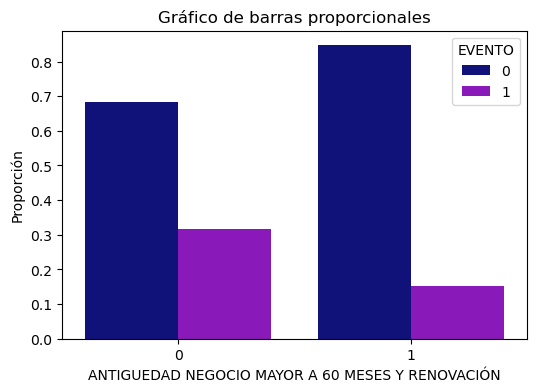

In [81]:
# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['ANTIGUEDAD_NEGOCIO_1_TIPO_VINCULACION_1', 'EVENTO']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('ANTIGUEDAD_NEGOCIO_1_TIPO_VINCULACION_1')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(data=counts, x="ANTIGUEDAD_NEGOCIO_1_TIPO_VINCULACION_1", y='proportion', palette=['darkblue', 'darkviolet'], hue='EVENTO')

# Personalizar el gráfico
plt.xlabel('ANTIGUEDAD NEGOCIO MAYOR A 60 MESES Y RENOVACIÓN')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [82]:
counts

,ANTIGUEDAD_NEGOCIO_1_TIPO_VINCULACION_1,EVENTO,count,proportion
0,0,0,10492,0.682762
1,0,1,4875,0.317238
2,1,0,4189,0.846605
3,1,1,759,0.153395


<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='CIIU_2_GENERO_1', ylabel='proportion'>

Text(0.5, 0, 'CIIU ALTA FREC. PROPORCION MALOS>=27% Y MASCULINO')

Text(0, 0.5, 'Proporción')

Text(0.5, 1.0, 'Gráfico de barras proporcionales')

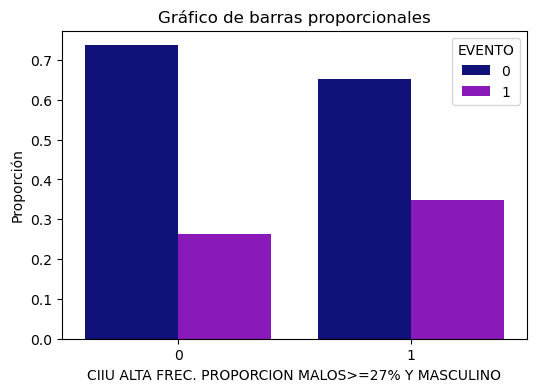

In [83]:
# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['CIIU_2_GENERO_1', 'EVENTO']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('CIIU_2_GENERO_1')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(data=counts, x="CIIU_2_GENERO_1", y='proportion', palette=['darkblue', 'darkviolet'], hue='EVENTO')

# Personalizar el gráfico
plt.xlabel('CIIU ALTA FREC. PROPORCION MALOS>=27% Y MASCULINO')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [84]:
counts

,CIIU_2_GENERO_1,EVENTO,count,proportion
0,0,0,12493,0.736746
1,0,1,4464,0.263254
2,1,0,2188,0.651578
3,1,1,1170,0.348422


<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='CIUDAD_1_ACTIVOS_TOTAL_1', ylabel='proportion'>

Text(0.5, 0, 'CIUDAD:BOGOTA, BUCARAMANGA, IBAGUE, MONTERIA, SINCELEJO,\n VALLEDUPAR Y ACTIVOS TOTAL<=22.02 SMLV')

Text(0, 0.5, 'Proporción')

Text(0.5, 1.0, 'Gráfico de barras proporcionales')

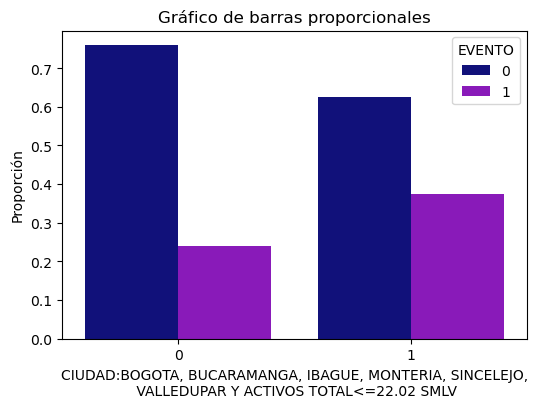

In [85]:
# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['CIUDAD_1_ACTIVOS_TOTAL_1', 'EVENTO']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('CIUDAD_1_ACTIVOS_TOTAL_1')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(data=counts, x="CIUDAD_1_ACTIVOS_TOTAL_1", y='proportion', palette=['darkblue', 'darkviolet'], hue='EVENTO')

# Personalizar el gráfico
plt.xlabel('CIUDAD:BOGOTA, BUCARAMANGA, IBAGUE, MONTERIA, SINCELEJO,\n VALLEDUPAR Y ACTIVOS TOTAL<=22.02 SMLV')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [86]:
counts

,CIUDAD_1_ACTIVOS_TOTAL_1,EVENTO,count,proportion
0,0,0,11165,0.759679
1,0,1,3532,0.240321
2,1,0,3516,0.625845
3,1,1,2102,0.374155


<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='CIUDAD_1_TIPO_VIVIENDA_3', ylabel='proportion'>

Text(0.5, 0, 'CIUDAD:BOGOTA, BUCARAMANGA, IBAGUE, MONTERIA,\n SINCELEJO, VALLEDUPAR Y VIVIENDA ARRENDADA')

Text(0, 0.5, 'Proporción')

Text(0.5, 1.0, 'Gráfico de barras proporcionales')

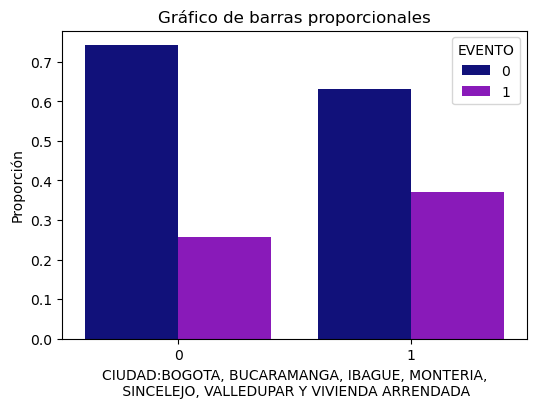

In [87]:
# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['CIUDAD_1_TIPO_VIVIENDA_3', 'EVENTO']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('CIUDAD_1_TIPO_VIVIENDA_3')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(data=counts, x="CIUDAD_1_TIPO_VIVIENDA_3", y='proportion', palette=['darkblue', 'darkviolet'], hue='EVENTO')

# Personalizar el gráfico
plt.xlabel('CIUDAD:BOGOTA, BUCARAMANGA, IBAGUE, MONTERIA,\n SINCELEJO, VALLEDUPAR Y VIVIENDA ARRENDADA')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [88]:
counts

,CIUDAD_1_TIPO_VIVIENDA_3,EVENTO,count,proportion
0,0,0,12422,0.742454
1,0,1,4309,0.257546
2,1,0,2259,0.630301
3,1,1,1325,0.369699


<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='CIUDAD_1_TOTAL_PASIVOS_1', ylabel='proportion'>

Text(0.5, 0, 'CIUDAD:BOGOTA, BUCARAMANGA, IBAGUE, MONTERIA,\n SINCELEJO, VALLEDUPAR Y TOTAL PASIVOS <= 2.89 SMLV')

Text(0, 0.5, 'Proporción')

Text(0.5, 1.0, 'Gráfico de barras proporcionales')

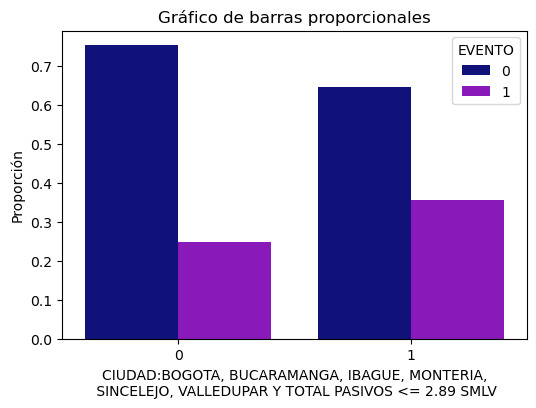

In [89]:
counts = df1.groupby(['CIUDAD_1_TOTAL_PASIVOS_1', 'EVENTO']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('CIUDAD_1_TOTAL_PASIVOS_1')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(data=counts, x="CIUDAD_1_TOTAL_PASIVOS_1", y='proportion', palette=['darkblue', 'darkviolet'], hue='EVENTO')

# Personalizar el gráfico
plt.xlabel('CIUDAD:BOGOTA, BUCARAMANGA, IBAGUE, MONTERIA,\n SINCELEJO, VALLEDUPAR Y TOTAL PASIVOS <= 2.89 SMLV')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [90]:
counts

,CIUDAD_1_TOTAL_PASIVOS_1,EVENTO,count,proportion
0,0,0,11009,0.752495
1,0,1,3621,0.247505
2,1,0,3672,0.645910
3,1,1,2013,0.354090


<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='CIUDAD_3_EDAD_3', ylabel='proportion'>

Text(0.5, 0, 'CIUDAD: CUCUTA, FLORENCIA, NEIVA Y EDAD > 41 ')

Text(0, 0.5, 'Proporción')

Text(0.5, 1.0, 'Gráfico de barras proporcionales')

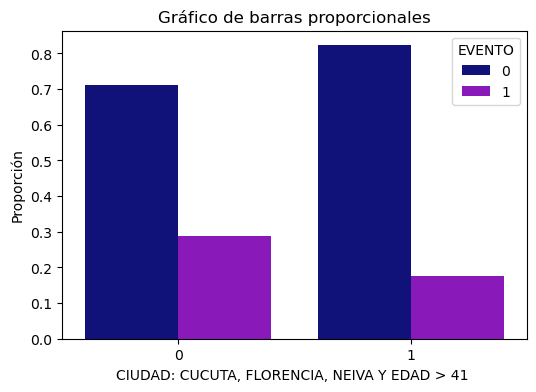

In [91]:
# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['CIUDAD_3_EDAD_3', 'EVENTO']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('CIUDAD_3_EDAD_3')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(data=counts, x="CIUDAD_3_EDAD_3", y='proportion', palette=['darkblue', 'darkviolet'], hue='EVENTO')

# Personalizar el gráfico
plt.xlabel('CIUDAD: CUCUTA, FLORENCIA, NEIVA Y EDAD > 41 ')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [92]:
counts

,CIUDAD_3_EDAD_3,EVENTO,count,proportion
0,0,0,12955,0.711149
1,0,1,5262,0.288851
2,1,0,1726,0.822688
3,1,1,372,0.177312


<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='CIUDAD_3_TIPO_VINCULACION_1', ylabel='proportion'>

Text(0.5, 0, 'CIUDAD: CUCUTA, FLORENCIA, NEIVA Y RENOVACIÓN')

Text(0, 0.5, 'Proporción')

Text(0.5, 1.0, 'Gráfico de barras proporcionales')

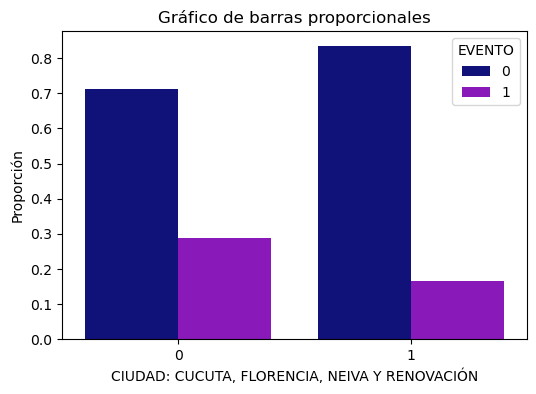

In [93]:
# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['CIUDAD_3_TIPO_VINCULACION_1', 'EVENTO']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('CIUDAD_3_TIPO_VINCULACION_1')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(data=counts, x="CIUDAD_3_TIPO_VINCULACION_1", y='proportion', palette=['darkblue', 'darkviolet'], hue='EVENTO')

# Personalizar el gráfico
plt.xlabel('CIUDAD: CUCUTA, FLORENCIA, NEIVA Y RENOVACIÓN')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [94]:
counts

,CIUDAD_3_TIPO_VINCULACION_1,EVENTO,count,proportion
0,0,0,13240,0.712249
1,0,1,5349,0.287751
2,1,0,1441,0.834878
3,1,1,285,0.165122


<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='EDAD_2_TIPO_VINCULACION_1', ylabel='proportion'>

Text(0.5, 0, '22< EDAD <= 41 Y RENOVACIÓN')

Text(0, 0.5, 'Proporción')

Text(0.5, 1.0, 'Gráfico de barras proporcionales')

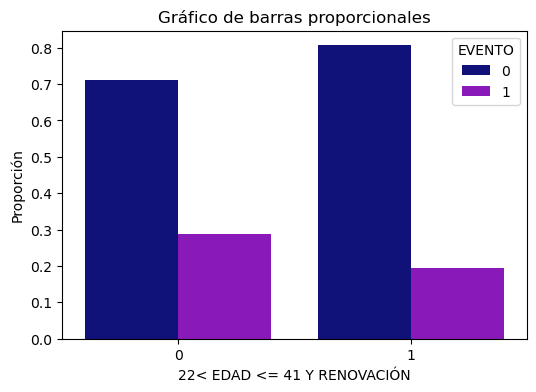

In [95]:
# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['EDAD_2_TIPO_VINCULACION_1', 'EVENTO']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('EDAD_2_TIPO_VINCULACION_1')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(data=counts, x="EDAD_2_TIPO_VINCULACION_1", y='proportion', palette=['darkblue', 'darkviolet'], hue='EVENTO')

# Personalizar el gráfico
plt.xlabel('22< EDAD <= 41 Y RENOVACIÓN')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [96]:
counts

,EDAD_2_TIPO_VINCULACION_1,EVENTO,count,proportion
0,0,0,12671,0.710975
1,0,1,5151,0.289025
2,1,0,2010,0.806258
3,1,1,483,0.193742


<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='EDAD_3_TIPO_VINCULACION_1', ylabel='proportion'>

Text(0.5, 0, 'EDAD > 41 Y RENOVACIÓN')

Text(0, 0.5, 'Proporción')

Text(0.5, 1.0, 'Gráfico de barras proporcionales')

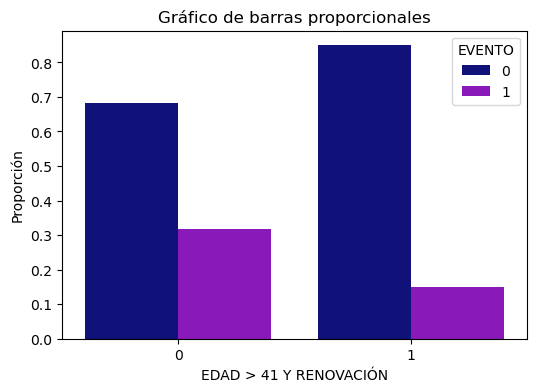

In [97]:
# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['EDAD_3_TIPO_VINCULACION_1', 'EVENTO']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('EDAD_3_TIPO_VINCULACION_1')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(data=counts, x="EDAD_3_TIPO_VINCULACION_1", y='proportion', palette=['darkblue', 'darkviolet'], hue='EVENTO')

# Personalizar el gráfico
plt.xlabel('EDAD > 41 Y RENOVACIÓN')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [98]:
counts

,EDAD_3_TIPO_VINCULACION_1,EVENTO,count,proportion
0,0,0,10513,0.682352
1,0,1,4894,0.317648
2,1,0,4168,0.849226
3,1,1,740,0.150774


<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='ESTADO_CIVIL_1', ylabel='proportion'>

Text(0.5, 0, 'ESTADO CIVIL: SOLTERO,DIVORCIADO, SEPARADO')

Text(0, 0.5, 'Proporción')

Text(0.5, 1.0, 'Gráfico de barras proporcionales')

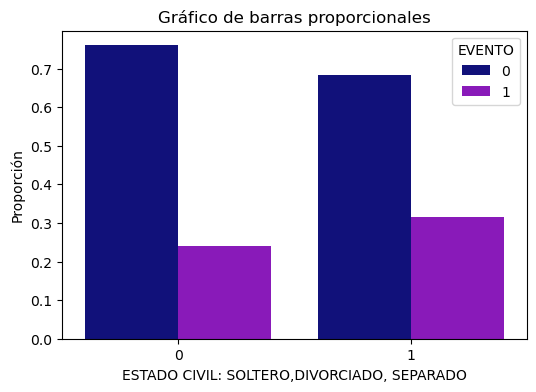

In [99]:
counts = df1.groupby(['ESTADO_CIVIL_1', 'EVENTO']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('ESTADO_CIVIL_1')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(data=counts, x="ESTADO_CIVIL_1", y='proportion', palette=['darkblue', 'darkviolet'], hue='EVENTO')

# Personalizar el gráfico
plt.xlabel('ESTADO CIVIL: SOLTERO,DIVORCIADO, SEPARADO')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [100]:
counts

,ESTADO_CIVIL_1,EVENTO,count,proportion
0,0,0,7900,0.760054
1,0,1,2494,0.239946
2,1,0,6781,0.683500
3,1,1,3140,0.316500


<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='ESTADO_CIVIL_1_TIPO_VINCULACION_1', ylabel='proportion'>

Text(0.5, 0, 'ESTADO CIVIL: SOLTERO,DIVORCIADO, SEPARADO Y RENOVACIÓN')

Text(0, 0.5, 'Proporción')

Text(0.5, 1.0, 'Gráfico de barras proporcionales')

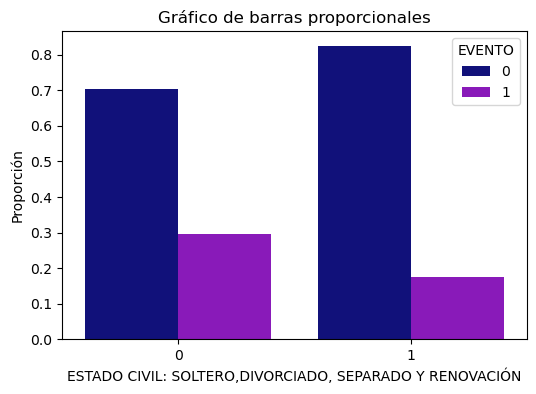

In [101]:
counts = df1.groupby(['ESTADO_CIVIL_1_TIPO_VINCULACION_1', 'EVENTO']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('ESTADO_CIVIL_1_TIPO_VINCULACION_1')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(data=counts, x="ESTADO_CIVIL_1_TIPO_VINCULACION_1", y='proportion', palette=['darkblue', 'darkviolet'], hue='EVENTO')

# Personalizar el gráfico
plt.xlabel('ESTADO CIVIL: SOLTERO,DIVORCIADO, SEPARADO Y RENOVACIÓN')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [102]:
counts

,ESTADO_CIVIL_1_TIPO_VINCULACION_1,EVENTO,count,proportion
0,0,0,12173,0.70466
1,0,1,5102,0.29534
2,1,0,2508,0.82500
3,1,1,532,0.17500


<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='SCORE_1', ylabel='proportion'>

Text(0.5, 0, 'SCORE <= 575')

Text(0, 0.5, 'Proporción')

Text(0.5, 1.0, 'Gráfico de barras proporcionales')

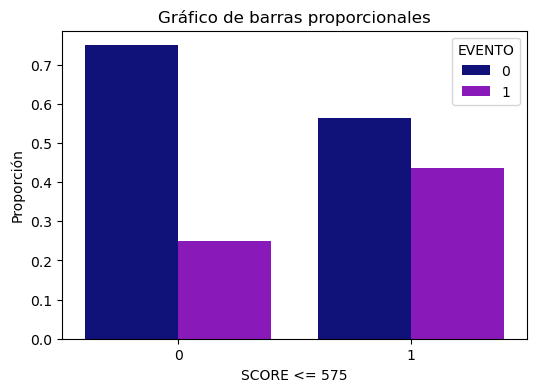

In [103]:
# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['SCORE_1', 'EVENTO']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('SCORE_1')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(data=counts, x="SCORE_1", y='proportion', palette=['darkblue', 'darkviolet'], hue='EVENTO')

# Personalizar el gráfico
plt.xlabel('SCORE <= 575')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [104]:
counts

,SCORE_1,EVENTO,count,proportion
0,0,0,13048,0.749239
1,0,1,4367,0.250761
2,1,0,1633,0.563103
3,1,1,1267,0.436897


<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='SCORE_3', ylabel='proportion'>

Text(0.5, 0, '684 < SCORE <= 830')

Text(0, 0.5, 'Proporción')

Text(0.5, 1.0, 'Gráfico de barras proporcionales')

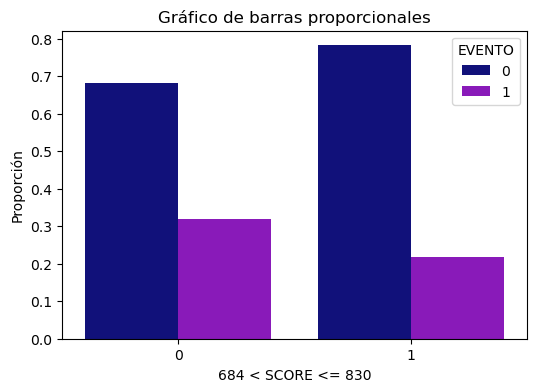

In [105]:
# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['SCORE_3', 'EVENTO']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('SCORE_3')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(data=counts, x="SCORE_3", y='proportion', palette=['darkblue', 'darkviolet'], hue='EVENTO')

# Personalizar el gráfico
plt.xlabel('684 < SCORE <= 830')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [106]:
counts

,SCORE_3,EVENTO,count,proportion
0,0,0,8168,0.681519
1,0,1,3817,0.318481
2,1,0,6513,0.781873
3,1,1,1817,0.218127


<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='SCORE_4', ylabel='proportion'>

Text(0.5, 0, 'SCORE > 830')

Text(0, 0.5, 'Proporción')

Text(0.5, 1.0, 'Gráfico de barras proporcionales')

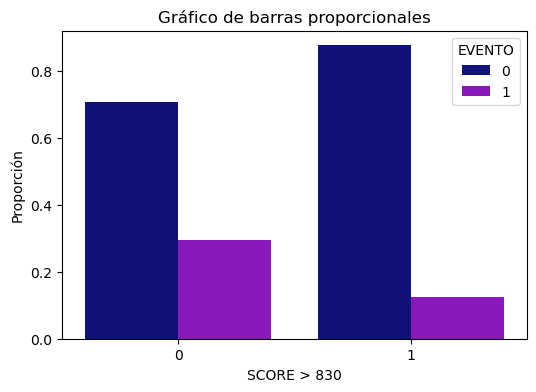

In [107]:
# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['SCORE_4', 'EVENTO']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('SCORE_4')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(data=counts, x="SCORE_4", y='proportion', palette=['darkblue', 'darkviolet'], hue='EVENTO')

# Personalizar el gráfico
plt.xlabel('SCORE > 830')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [108]:
counts

,SCORE_4,EVENTO,count,proportion
0,0,0,12926,0.705876
1,0,1,5386,0.294124
2,1,0,1755,0.876186
3,1,1,248,0.123814


<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='TIPO_VIVIENDA_1', ylabel='proportion'>

Text(0.5, 0, 'TIPO DE VIVIENDA: PROPIA')

Text(0, 0.5, 'Proporción')

Text(0.5, 1.0, 'Gráfico de barras proporcionales')

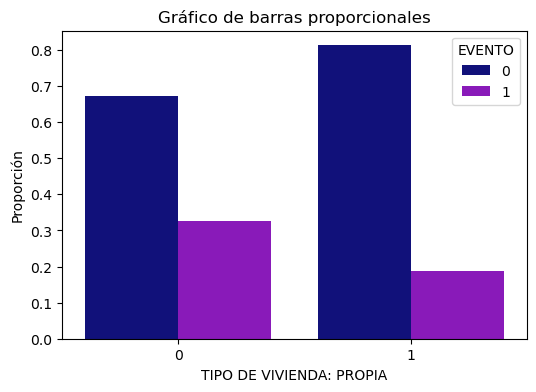

In [109]:
# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['TIPO_VIVIENDA_1', 'EVENTO']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('TIPO_VIVIENDA_1')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(data=counts, x="TIPO_VIVIENDA_1", y='proportion', palette=['darkblue', 'darkviolet'], hue='EVENTO')

# Personalizar el gráfico
plt.xlabel('TIPO DE VIVIENDA: PROPIA')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [110]:
counts

,TIPO_VIVIENDA_1,EVENTO,count,proportion
0,0,0,8783,0.672563
1,0,1,4276,0.327437
2,1,0,5898,0.812845
3,1,1,1358,0.187155


<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='TIPO_VIVIENDA_3', ylabel='proportion'>

Text(0.5, 0, 'TIPO DE VIVIENDA: ARRENDADA')

Text(0, 0.5, 'Proporción')

Text(0.5, 1.0, 'Gráfico de barras proporcionales')

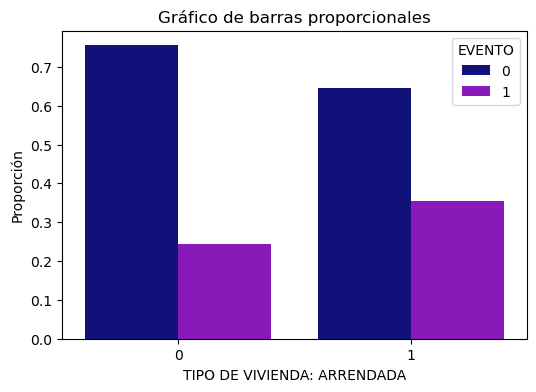

In [111]:
# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['TIPO_VIVIENDA_3', 'EVENTO']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('TIPO_VIVIENDA_3')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(data=counts, x="TIPO_VIVIENDA_3", y='proportion', palette=['darkblue', 'darkviolet'], hue='EVENTO')

# Personalizar el gráfico
plt.xlabel('TIPO DE VIVIENDA: ARRENDADA')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [112]:
counts

,TIPO_VIVIENDA_3,EVENTO,count,proportion
0,0,0,10827,0.755337
1,0,1,3507,0.244663
2,1,0,3854,0.644374
3,1,1,2127,0.355626


<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='TOTAL_PASIVOS_1', ylabel='proportion'>

Text(0.5, 0, 'TOTAL PASIVOS <= 2.89')

Text(0, 0.5, 'Proporción')

Text(0.5, 1.0, 'Gráfico de barras proporcionales')

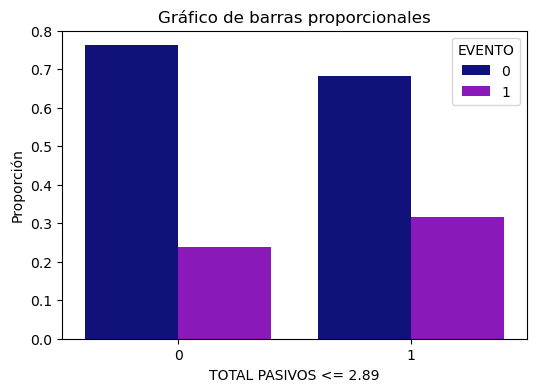

In [113]:
# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['TOTAL_PASIVOS_1', 'EVENTO']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('TOTAL_PASIVOS_1')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(data=counts, x="TOTAL_PASIVOS_1", y='proportion', palette=['darkblue', 'darkviolet'], hue='EVENTO')

# Personalizar el gráfico
plt.xlabel('TOTAL PASIVOS <= 2.89')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [114]:
counts

,TOTAL_PASIVOS_1,EVENTO,count,proportion
0,0,0,7784,0.762315
1,0,1,2427,0.237685
2,1,0,6897,0.682601
3,1,1,3207,0.317399


<Figure size 600x400 with 0 Axes>

<AxesSubplot:xlabel='TOTAL_PASIVOS_2_RAZON_PASIVOS_ACTIVOS_2', ylabel='proportion'>

Text(0.5, 0, '2.89 < TOTAL_PASIVOS <= 28 SMLV Y \n 0.01612 < RAZÓN PASIVOS ACTIVOS <= 0.34681')

Text(0, 0.5, 'Proporción')

Text(0.5, 1.0, 'Gráfico de barras proporcionales')

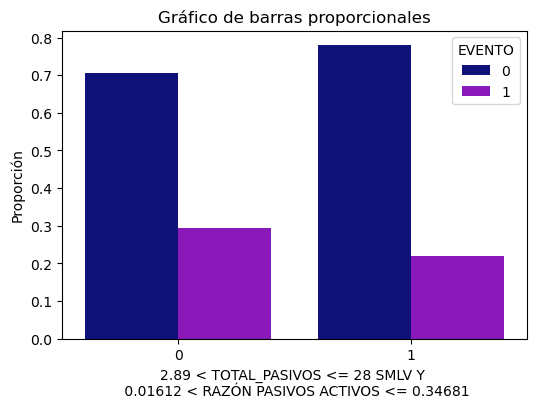

In [117]:
# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['TOTAL_PASIVOS_2_RAZON_PASIVOS_ACTIVOS_2', 'EVENTO']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('TOTAL_PASIVOS_2_RAZON_PASIVOS_ACTIVOS_2')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(data=counts, x="TOTAL_PASIVOS_2_RAZON_PASIVOS_ACTIVOS_2", y='proportion', palette=['darkblue', 'darkviolet'], hue='EVENTO')

# Personalizar el gráfico
plt.xlabel('2.89 < TOTAL_PASIVOS <= 28 SMLV Y \n 0.01612 < RAZÓN PASIVOS ACTIVOS <= 0.34681')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [116]:
counts

,TOTAL_PASIVOS_2_RAZON_PASIVOS_ACTIVOS_2,EVENTO,count,proportion
0,0,0,11008,0.705460
1,0,1,4596,0.294540
2,1,0,3673,0.779665
3,1,1,1038,0.220335


In [84]:
df1['SCORE_log']=np.log(df1['SCORE'])
#df['mora_2_a_log']=np.log(df['mora_2_a'])
#df['DIAS_SISTEMA_log']=np.log(df['DIAS_SISTEMA'])
#df['CUPO_log']=np.log(df['CUPO'])
#df1['saldo_capital_202202_log']=np.log(df1['saldo_capital_202202'])
#df1['edad_log']=np.log(df1['edad'])

In [86]:
df1['SCORE_log']

0        6.486161
1        6.568078
2        6.429719
3        6.654153
4        6.408529
           ...   
19000    6.665684
19001    6.638568
19002    6.452049
19003    6.688355
19004    6.508769
Name: SCORE_log, Length: 19005, dtype: float64

ValueError: Could not interpret value `SCORE_log` for parameter `x`

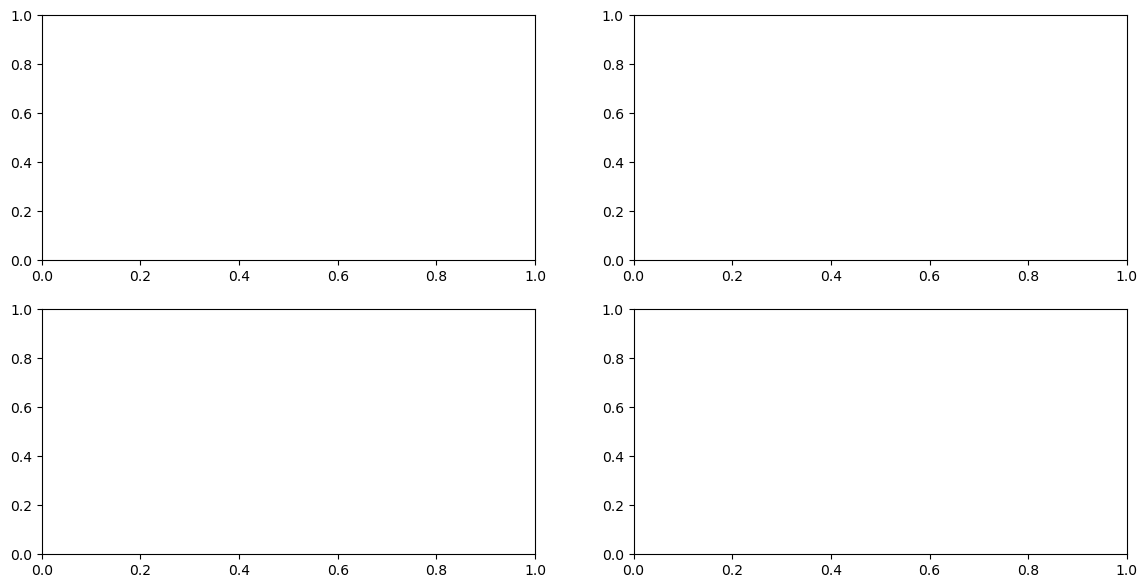

In [87]:
fig, axs = plt.subplots(2, 2, figsize=(14, 7))

sb.histplot(df=df1, x='SCORE_log', hue='EVENTO', kde=True, palette=['darkblue', 'darkgreen'], ax=axs[0, 0])
sb.histplot(df=df1, x='VENTAS', hue='EVENTO', kde=True, palette=['darkblue', 'darkgreen'], ax=axs[0, 1])
sb.histplot(df=df1, x='RAZON_PASIVOS_ACTIVOS', hue='EVENTO', kde=True, palette=['darkblue', 'darkgreen'], ax=axs[1, 0])
sb.histplot(df=df1, x='EDAD', hue='EVENTO', kde=True, palette=['darkblue', 'darkgreen'], ax=axs[1, 1])

In [ ]:
sb.set_theme(style="whitegrid")
penguins = sb.load_dfset("penguins")

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [ ]:
df1=df[variables3]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['FRANJA_0_D', 'evento']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('FRANJA_0_D')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(df=counts, x='FRANJA_0_D', y='proportion',palette=['darkblue', 'darkgreen'], hue='evento')

# Personalizar el gráfico
plt.xlabel('FRANJA_0_D')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [ ]:
counts.to_excel('C:/Users/damartinezp/Documents/Proyectos Borrador/PD_C1/202205_modelo/Descriptivas/FRANJA_0_D_frec_rta.xlsx', index=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['TP_pp', 'evento']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('TP_pp')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(df=counts, x='TP_pp', y='proportion',palette=['darkblue', 'darkgreen'], hue='evento')

# Personalizar el gráfico
plt.xlabel('TP_pp')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [ ]:
counts.to_excel('C:/Users/damartinezp/Documents/Proyectos Borrador/PD_C1/202205_modelo/Descriptivas/TP_pp_frec_rta.xlsx', index=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['FRANJA_31_90_D', 'evento']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('FRANJA_31_90_D')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(df=counts, x='FRANJA_31_90_D', y='proportion',palette=['darkblue', 'darkgreen'], hue='evento')

# Personalizar el gráfico
plt.xlabel('FRANJA_31_90_D')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [ ]:
counts.to_excel('C:/Users/damartinezp/Documents/Proyectos Borrador/PD_C1/202205_modelo/Descriptivas/FRANJA_31_90_D_frec_rta.xlsx', index=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['PR_O_D', 'evento']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('PR_O_D')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(df=counts, x='PR_O_D', y='proportion',palette=['darkblue', 'darkgreen'], hue='evento')

# Personalizar el gráfico
plt.xlabel('PR_O_D')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [ ]:
counts.to_excel('C:/Users/damartinezp/Documents/Proyectos Borrador/PD_C1/202205_modelo/Descriptivas/PR_O_D_frec_rta.xlsx', index=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['PR_1_D', 'evento']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('PR_1_D')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(df=counts, x='PR_1_D', y='proportion', palette=['darkblue', 'darkgreen'], hue='evento')

# Personalizar el gráfico
plt.xlabel('PR_1_D')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [ ]:
counts.to_excel('C:/Users/damartinezp/Documents/Proyectos Borrador/PD_C1/202205_modelo/Descriptivas/PR_1_D_frec_rta.xlsx', index=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['P_MP6', 'evento']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('P_MP6')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(df=counts, x='P_MP6', y='proportion', palette=['darkblue', 'darkgreen'], hue='evento')

# Personalizar el gráfico
plt.xlabel('P_MP6')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [ ]:
counts.to_excel('C:/Users/damartinezp/Documents/Proyectos Borrador/PD_C1/202205_modelo/Descriptivas/P_MP6_frec_rta.xlsx', index=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(["P_Dis", 'evento']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby("P_Dis")['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(df=counts, x="P_Dis", y='proportion', palette=['darkblue', 'darkgreen'], hue='evento')

# Personalizar el gráfico
plt.xlabel("P_Dis")
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [ ]:
counts.to_excel('C:/Users/damartinezp/Documents/Proyectos Borrador/PD_C1/202205_modelo/Descriptivas/P_Dis_frec_rta.xlsx', index=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(["PR_AGRUP", 'evento']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby("PR_AGRUP")['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(df=counts, x="PR_AGRUP", y='proportion', palette=['darkblue', 'darkgreen'], hue='evento')

# Personalizar el gráfico
plt.xlabel("PR_AGRUP")
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [ ]:
counts.to_excel('C:/Users/damartinezp/Documents/Proyectos Borrador/PD_C1/202205_modelo/Descriptivas/PR_AGRUP_frec_rta.xlsx', index=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener los conteos de cada combinación de categorías
counts = df1.groupby(['C_AuM', 'evento']).size().reset_index(name='count')

# Calcular las frecuencias relativas
counts['proportion'] = counts.groupby('C_AuM')['count'].transform(lambda x: x / x.sum())

# Configurar el tamaño del gráfico
plt.figure(figsize=(6, 4))

# Crear el gráfico de barras proporcionales utilizando barplot de Seaborn
sns.barplot(df=counts, x='C_AuM', y='proportion', palette=['darkblue', 'darkgreen'], hue='evento')

# Personalizar el gráfico
plt.xlabel('C_AuM')
plt.ylabel('Proporción')
plt.title('Gráfico de barras proporcionales')

# Mostrar el gráfico
plt.show()

In [ ]:
counts.to_excel('C:/Users/damartinezp/Documents/Proyectos Borrador/PD_C1/202205_modelo/Descriptivas/C_AuM_frec_rta.xlsx', index=True)

## Descriptiva PD CrediUno

In [ ]:
df = pd.read_excel("C:/Users/damartinezp/Documents/Proyectos Borrador/PD_C1/Resumen_PD_C1.xlsx")

In [ ]:
df.Fecha=pd.to_datetime(df.Fecha)
df1=df.set_index('Fecha')#indica que la serie es mensual
PD_C1=df1['PD_C1']##Convertir en serie de tiempo
PD_C1=PD_C1.dropna()

In [ ]:
PD_C1=pd.dfFrame(PD_C1)

In [ ]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(PD_C1, color='b', label='PD_C1')
ax.set_xlabel('Mes')
ax.set_title('PD CREDIUNO 2017-2022')
ax.grid(True)
ax.legend(loc='upper left');